## Kaggle 2019 Data Science Bowl

This notebook contains my submissions to the 2019 Kaggle Data Science Bowl, a supervised learning competition. The data comes from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors were challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes.

The work is organized as follows:

1. [Data Load and Inspection](#one)
2. [EDA](#two)
3. [Ground Truth](#three)
4. [Feature engineering](#four)
5. [Feature transformations](#five)
5. [Pre-processing](#six)
6. [Evaluation: Quadratic Weighted Kappa (qwk)](#seven)
7. [Models](#eight)
    - [KNN Model](#eighta)
    - [SVM Model](#eightb)
    - [Decision Tree Model(single)](#eightc)
    - [Gradient Boosted Tree Model](#eightd)
8. [Discussion and Takeaways](#nine)

## 1. Data Loading and Inspection <a id='one'></a>

In [93]:
# imports
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
import datetime
from tqdm.auto import tqdm
from collections import Counter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
# %load_ext line_profiler

In [18]:
basepath = '../../../../dsb_data/'
train = pd.read_csv(basepath + 'processed/train.csv/train.csv') #df.head()

In [16]:
test = pd.read_csv(basepath + 'processed/test.csv/test.csv') #df.head()

In [4]:
print('Training.csv file has {} rows and {} columns'.format(train.shape[0], train.shape[1]))

Training.csv file has 11341042 rows and 11 columns


In [5]:
print('Test.csv file has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Test.csv file has 1156414 rows and 11 columns


In [21]:
specs = pd.read_csv('../references/specs.csv')
print('specs.csv file has {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

specs.csv file has 386 rows and 3 columns


In [22]:
train_labels = pd.read_csv('../references/train_labels.csv/train_labels.csv')
print('train_lablels.csv file has {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))
#train_labels

train_lablels.csv file has 17690 rows and 7 columns


In [23]:
sample = pd.read_csv('../references/sample_submission.csv')
print('sample submission file has {} rows and {} columns'.format(sample.shape[0], sample.shape[1]))

sample submission file has 1000 rows and 2 columns


## 2. EDA <a id='two'></a>

Each installation_id is roughly equivalent to a user. let's see how many installation_ids there are

In [26]:
users = train.installation_id.unique()
len(users) # number of distinct users

17000

There are 17000 unique installation_id's in the training set. Let's examine the breakdown of event types for a sample: `installation_id =='0001e90f'` (from the first row in the dataset)

In [24]:
types = train.loc[train['installation_id']=='0001e90f'].groupby(['type'],as_index=False).size().reset_index(name='counts')
types

,type,counts
0,Activity,469
1,Clip,5
2,Game,883


Below i calculate the total time spent on each different types of events in minutes for each installation_id. 

In [40]:
N=500    # how many users to aggregate over in train set
user_times = np.zeros(N)
times_per_type = [0,0,0,0]
for j in tqdm(range(N)):
    user = users[j]
    event_types = [0,0,0,0]
    sessions_typed = [0,0,0,0]
    user_dat = train.loc[(train['installation_id']==user)]
    event_types[0] = user_dat.loc[user_dat['type'] == 'Activity']
    sessions_typed[0] = event_types[0]['game_session'].unique()
    event_types[1] = user_dat.loc[user_dat['type'] == 'Clip']
    sessions_typed[1] = event_types[1]['game_session'].unique()
    event_types[2] = user_dat.loc[user_dat['type'] == 'Game']
    sessions_typed[2] = event_types[2]['game_session'].unique()
    event_types[3]   = user_dat.loc[user_dat['type'] == 'Assessment']
    sessions_typed[3] = event_types[3]['game_session'].unique()
        
    for i in range(4):
        type_time = 0.0
        for session in sessions_typed[i]:
            
            #there may be an issue where there are NO events and then it doesn't figure this out??
            sesh_start_ts = event_types[i].loc[event_types[i]['game_session']==session]['timestamp'].min()
            sesh_start_dt = datetime.datetime.strptime(sesh_start_ts,'%Y-%m-%dT%H:%M:%S.%fZ')
            sesh_end_ts = event_types[i].loc[event_types[i]['game_session']==session]['timestamp'].max()
            sesh_end_dt = datetime.datetime.strptime(sesh_end_ts,'%Y-%m-%dT%H:%M:%S.%fZ')

            type_time = type_time + (sesh_end_dt - sesh_start_dt).total_seconds()/60.0
            times_per_type[i]+=type_time
        
    total_time = sum(times_per_type)
    user_times[j] = total_time

Below I plot the times in terms of the playing category -- we can see that kids spent most of the time playing games or activities and a little bit of time on assessments. Clip seems unimportant.

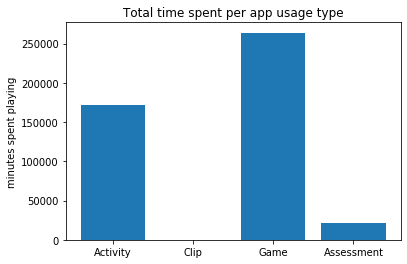

In [48]:
p2 = plt.bar([1,2,3,4], times_per_type);

plt.title('Total time spent per app usage type');
plt.ylabel('minutes spent playing')
plt.xticks([1,2,3,4], ('Activity', 'Clip', 'Game', 'Assessment'));

## 3. Ground truth  <a id='three'></a>

Note that the Bird Measurer assessment has two parts however we consider the it to be passed correctly if just the first part is passed, that is the 4110 code. Here, I duplicate the train_labels that were provided by parsing the train data set and calculating the accuracy. 

In [53]:
assessments = train.loc[(train['type'] == 'Assessment') & (((train['event_code'] == 4100)&(train['title'] != 'Bird Measurer (Assessment)')) | (train['event_code'] == 4110))].copy()
assessments['num_correct'] = True

test_assessments = test.loc[(test['type'] == 'Assessment') & (((test['event_code'] == 4100)&(test['title'] != 'Bird Measurer (Assessment)')) | (test['event_code'] == 4110))].copy()
test_assessments_for_union = test_assessments.copy()

test_assessments['num_correct'] = True    # initialize all assessments as succeeding

assessments.loc[assessments['event_data'].str.contains(":false,"),'num_correct'] = False   # update labels where user incorrect

test_assessments.loc[test_assessments['event_data'].str.contains(":false,"),'num_correct'] = False  # ditto on test set

assessments['num_incorrect'] = np.where(assessments.num_correct > 0,0,1)   # label incorrect

test_assessments['num_incorrect'] = np.where(test_assessments.num_correct > 0,0,1)

The way I calculate the number of incorrect assessments is using a groupby(). We need to know both number incorrect as well as if there was a correct answer in separate columns. I chose two separately create these two columns and then merge them using an inner join, however this is probably not best practice, there is probably a way to create two aggregate columns in a single step without creating two dataframes (stackoverflow this) perhaps using the agg() function  for multiple aggregations - that might do the trick

In [55]:
g = assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_correct'].sum().sort_values(by=['installation_id'])
h = assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_incorrect'].sum().sort_values(by=['installation_id'])

ggg = test_assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_correct'].sum().sort_values(by=['installation_id'])
hhh = test_assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_incorrect'].sum().sort_values(by=['installation_id'])

g['num_correct'] = g['num_correct'].astype(int)      #g.shape
h['num_incorrect'] = h['num_incorrect'].astype(int)   #h.shape

ggg['num_correct'] = ggg['num_correct'].astype(int)      #g.shape
hhh['num_incorrect'] = hhh['num_incorrect'].astype(int)   #h.shape

merged_inner = pd.merge(left=g,right=h, left_on='game_session', right_on='game_session')

test_merged_inner = pd.merge(left=ggg,right=hhh, left_on='game_session', right_on='game_session')

df1 = merged_inner[['game_session','installation_id_x','title_x','num_correct','num_incorrect']]
df2 = test_merged_inner[['game_session','installation_id_x','title_x','num_correct','num_incorrect']] 
pd.options.mode.chained_assignment = None
df1.rename(columns = {'installation_id_x':'installation_id'}, inplace = True)
df1.rename(columns = {'title_x':'title'}, inplace = True)
df2.rename(columns = {'installation_id_x':'installation_id'}, inplace = True)
df2.rename(columns = {'title_x':'title'}, inplace = True)

df1['accuracy'] = df1.apply(lambda row: row.num_correct/(row.num_correct + row.num_incorrect), axis=1)
df2['accuracy'] = df2.apply(lambda row: row.num_correct/(row.num_correct + row.num_incorrect), axis=1)

In [57]:
# define accuracy groups

def groupacc(row):
    if row['num_correct'] == 1 and row['num_incorrect'] == 0:
        return 3
    if row['num_correct'] == 1 and row['num_incorrect'] == 1:
        return 2
    if row['num_correct'] == 1 and row['num_incorrect'] > 1:
        return 1
    if row['num_correct'] == 0: 
        return 0
    return 'Other'

df1['accuracy_group'] = df1.apply(groupacc, axis=1)
df2['accuracy_group'] = df2.apply(groupacc, axis=1)

# I did a check comparing my results to the provided train_labels

c = df1.sort_values(by=['game_session'])
k = train_labels.sort_values(by=['game_session'])

comparison_array = c.values == k.values

if False in comparison_array:
    print ("Not the same")
    
len(np.where(comparison_array==False)[0])  # 46 differences due to floating point stuff

Not the same


46

## 4. Feature engineering <a id='four'></a>

The target, e.g. `y`, is the accuracy group for an assessment session, e.g. this is what you are trying to predict.
The features, `X` are collected by looking up the user's historical data for each assessment session, you only want to consider data up to the current timestamp of the assessment you are training or predicting on (except for the type of assessment). Though it would be possible to incorporate historical data from test set into train, this would leak data from test into the model and also might hurt the build process mixing things up too much since the private test set is still withheld. It's a thought though, but probably wrong.


Let's pair down the train set to only the ids that actually took (e.g. started 2000) an assessment and also made an attempt (4100/4110) and do some more inspection, with comments detailing below. One issue is features which have NA for some data - (accumulated previous accuracy group) -> our approach will be to substitue the mean value for the type. Using 0 is another way which may produce better results. Below I start by doing some encodings.  We need to predict the score for the last assessment in the test set. Also, despite some unclear language in the instructions, after some effort it became clear to me from inspection that **the last assessment (by timestamp) has been truncated for each user in the test set**. Some of the test set users have no previous assessments to learn from. 


In [59]:
# Encode the assessment title

list_of_assessment_titles = list(set(assessments['title'].unique()))
list_of_assessment_titles.sort()

assessment_titles_map = dict(zip(list_of_assessment_titles, np.arange(len(list_of_assessment_titles))))
assessment_titles_map

assessments['title'] = assessments['title'].map(assessment_titles_map)    # note if you run this twice it will break
train_labels['title'] = train_labels['title'].map(assessment_titles_map)  # note if you run this twice it will break

print(len(assessments['game_session'].unique()))  # unique sessions of type assesment in train set
train_reduced_users = assessments['installation_id'].unique()
print(len(train_reduced_users))  # unique users who made at least one attempt on an assessment in train

train = train.loc[train['installation_id'].isin(train_reduced_users)]  # drop some data where user has no assessment
#train.shape

test_users = test.installation_id.unique()    # installation_ids in test set
print(len(test_users))
len(set(test_users).intersection(set(users)))  # there is no intersection in installation_ids between train and test

# Combine the historical test portion with the predict set: which is the last assessment (no 4100/4110 code)

test_predict = test.loc[test['type'] == 'Assessment'].groupby('installation_id',as_index=False).last()

# you need to combine test_assessments so that it has those last rows basically do a union/concat at this stage

test_final_assessments = pd.concat([test_assessments_for_union,test_predict],sort=False)
test_final_assessments = test_final_assessments.sort_values(by=['installation_id','timestamp'])

# calculate mean group accuracies on train

mean_group_accs = train_labels.groupby('title',as_index=False).mean()['accuracy_group']
list(mean_group_accs)

17690
3614
1000


[1.3237436270939549,
 2.3004095398699107,
 2.306781750924784,
 0.8383092921838309,
 2.2142667021559754]

In [61]:
# the function to build train or test features. I don't think this code is efficient. In future consider using python
# Counter() function as a good resource. Also do some unncessary extra work looping through entire time history for each user 
# instead of working incrementally would definitely be more efficient

def build_features(num,test_or_train):

    N=num   # number of users to build data for, to go to production set N = len(train/test_users)
    features = []   # this will by the full data for each assessment   X  & Y
    build_test = test_or_train   # False

    for j in tqdm(range(N)):

        if build_test == False:
            user = train_reduced_users[j]   
            prev_hist = train.loc[train['installation_id']==user]   # for previous history counts, narrowed to user    
            user_assessments = assessments.loc[assessments['installation_id']==user]  # for previous cum_accuracy_grps    
            user_sessions = user_assessments['game_session'].unique()  # time ordered
        else:
            user = test_users[j]
            prev_hist = test.loc[test['installation_id']==user]   # for previous history counts, narrowed to user 
            user_sessions = test_final_assessments.loc[test_final_assessments['installation_id']==user]['game_session'].unique()

        counters = np.array([0.0,0.0,0.0,0.0,0.0])  # number of each type of assessment initialization
        cumalitive_acc_groups = np.array(list(mean_group_accs))   # initialization
        #cumalitive_acc_groups = np.array([0.0,0.0,0.0,0.0,0.0])   # alternative zero initialization

        magmapeak_counts = 0
        treetopcity_counts = 0
        crystalcaves_counts = 0

        game_counts = 0
        clip_counts = 0
        activity_counts = 0
        assess_counts = 0

        ii = 1

        for session in user_sessions:     # these are already time-ordered 

            # code to convert timestamp data to datetime data
            prev_hist['timestamp'] = pd.to_datetime(prev_hist['timestamp'])  # get the time at the start of the game_session
            the_time = prev_hist.loc[prev_hist['game_session']==session]['timestamp'].iloc[0]
            the_past = prev_hist.loc[prev_hist['timestamp'] < the_time]  # this could be empty!! 
            num_events = the_past.groupby('world',as_index=False).size().reset_index(name='counts')
            num_sessions_by_type = the_past.groupby('game_session',as_index=False).last().groupby('type').size().reset_index(name='tcounts')

            for index, row in num_sessions_by_type.iterrows():
                if row['type'] == 'Game':
                    game_counts = row['tcounts']
                if row['type'] == 'Activity':
                    activity_counts = row['tcounts']
                if row['type'] == 'Assessment':
                    assess_counts = row['tcounts'] 
                if row['type'] == 'Clip':
                    clip_counts = row['tcounts']

            # now you want to count number of previous events for this user before this timestamp

            user_features = []

            user_features.append(clip_counts)
            user_features.append(activity_counts)
            user_features.append(assess_counts)
            user_features.append(game_counts)  

            if build_test == False:
                sesh_dat = train_labels.loc[train_labels['game_session'] == session]
                score = sesh_dat['accuracy_group'].iloc[0]
            else:
                if ii < len(user_sessions):
                    sesh_dat = df2.loc[df2['game_session'] == session]
                    score = sesh_dat['accuracy_group'].iloc[0]
                else:
                    score = 0         

            title = prev_hist.loc[prev_hist['game_session']==session]['title'].iloc[0]   
            title = assessment_titles_map[title]
            
            #user_features.append(user)
            user_features.append(title)

            total_accum = np.sum(cumalitive_acc_groups)/(np.sum(counters)+5.0)
            user_features.append(cumalitive_acc_groups[0]/(counters[0]+1.0))
            user_features.append(cumalitive_acc_groups[1]/(counters[1]+1.0))
            user_features.append(cumalitive_acc_groups[2]/(counters[2]+1.0))
            user_features.append(cumalitive_acc_groups[3]/(counters[3]+1.0))
            user_features.append(cumalitive_acc_groups[4]/(counters[4]+1.0))

            if title == 0:
                counters[0] += 1
                cumalitive_acc_groups[0] = cumalitive_acc_groups[0] + score
            elif title == 1:
                counters[1] += 1
                cumalitive_acc_groups[1] = cumalitive_acc_groups[1] + score
            elif title == 2:
                counters[2] += 1
                cumalitive_acc_groups[2] = cumalitive_acc_groups[2] + score
            elif title == 3:
                counters[3] += 1
                cumalitive_acc_groups[3] = cumalitive_acc_groups[3] + score
            elif title == 4:
                counters[4] += 1
                cumalitive_acc_groups[4] = cumalitive_acc_groups[4] + score

            user_features.append(total_accum)

            user_features.append(score)

            for index, row in num_events.iterrows():
                if row['world'] == 'MAGMAPEAK':
                    magmapeak_counts = row['counts']
                if row['world'] == 'TREETOPCITY':
                    treetopcity_counts = row['counts']
                if row['world'] == 'CRYSTALCAVES':
                    crystalcaves_counts = row['counts']  

            user_features.append(magmapeak_counts)
            user_features.append(treetopcity_counts)
            user_features.append(crystalcaves_counts)
            user_features.append(sum(num_events['counts']) - (magmapeak_counts + treetopcity_counts+crystalcaves_counts))
            user_features.append(sum(num_events['counts']))
            
            if build_test == False:
                features.append(user_features)
            else:
                if ii == len(user_sessions):
                    features.append(user_features)
            ii += 1
            
    return features

Now it's time to build the train and test set. Alternatively, if we already built the train we can simply load it from csv

In [74]:
test = pd.DataFrame(build_features(len(test_users),True))
test = test.round(2)

#train = pd.DataFrame(build_features(len(train_reduced_users),False))
#train = train.round(2)

#train.to_csv('train.csv', index=False)

# to read in features that are already built uncomment belwo
#train = pd.read_csv('train.csv')


Alot more features could be included such as some **durations**... alot more could be done here but for now we just want to go ahead and get it to work and then we can come back to feature engineering later if we have time


## 5. Feature transformations <a id='five'></a>

I did not do any feature or target transformations. One idea for example is to log transform numerical data. You should consider this in later work.

## 6. Pre-processing  <a id='six'></a>

In [80]:
# preprocessing 

y_train = train['11']
y_test = test[11]
X_train = train.drop('11', axis=1)
X_test = test.drop(11, axis=1)

categorical = 4         # categoricals
#categorical = '4'   #  if you load train it reads header as string (alternatively cast header to int)

# or do this for some models

X_train['4'] = X_train['4'].astype('category') 

X_test[4]= X_test[4].astype('category') 

# dummy variable encoding (not always desired)

dumb = pd.get_dummies(X_train['4'],drop_first=True,prefix='g')
dumby = pd.get_dummies(X_test[categorical],drop_first=True,prefix='j')

X_train = X_train.drop(['4'],axis=1)
X_test = X_test.drop([categorical],axis=1)

X_train = pd.concat([X_train,dumb],axis=1)
X_test = pd.concat([X_test,dumby],axis=1)


# Feature scaling - if desired for model

X_scaled = preprocessing.scale(X_train)

X_test_scaled = preprocessing.scale(X_test)


## 7. Evaluation metric -  quadratic weighted kappa (qwk)  <a id='seven'></a>

This is a metric commonly used for measuring the aggreement between two raters where bigger differences are penalized (the squared). The outer product is simply coming from the assuming independent marginals on true and predicted sets (from histograms) and then computing the independent joint probability by multiplying. In order to optimize this metric a threshold optimizer is needed for models which output continuous preditions (e.g. regression objectives). Unfortunatel, I did not have time to build the optimizer and I preferred not to include someone else's optimizer here because my goal for this competition was to understand the method of building a good model rather than make a high prediction score

In [67]:
def qwk(a1,a2):
    N = 4
    o = confusion_matrix(a1,a2)
    w = np.zeros(shape=(N,N))
    for i in range(N):
        for j in range(N):
            w[i,j] = (i-j)**2
    w = w/((N-1)*(N-1)) 
    w = w.round(3)
    
    e = np.outer(np.histogram(a1, [i for i in range(N+1)])[0],np.histogram(a2,[i for i in range(N+1)])[0])

    e = e/np.sum(e)
    o = o/np.sum(o)

    return 1 - np.sum(np.multiply(o,w))/np.sum(np.multiply(e,w))


## 8. Models <a id='eight'></a>

Our approach to modelling is to work from simple models to complex models and to learn about how to implement each model correctly while building cross-validation into the pipeline as well. The idea for this competition is to learn how to build models, not neccessarily to win this competition... though that would be nice... I was able to successfully run the following models

1. KNN

2. Support Vector Machine

3. Single decision tree 

4. Gradient boosted tree ensemble - regression with thresholding


Models that I did not get time to try but which would be good

1. Neural Networks

2. Ridge/Logistic/Lasso regressions with/without thresholding

3. Multi-Layer Perceptrons

Different models handle categorical and numerical data differently in terms of feature transformations and scaling/preprocessing, this should be kept in mind.



### K nearest neighbors

<a id='eighta'></a>

Below we do cross-validation to see what value of k (the hyperparameter) optimizes. Smaller values of k lead to overfitting.
KNN is the dumbest of models but provides a starting point.

In [83]:
mean_scores = []
nns = []
stds = []
qwks_mean = []
for nn in tqdm(range(2,30,5)):
    
    cv = KFold(n_splits=5)
    neigh = KNeighborsClassifier(n_neighbors = nn)
    
    scores = []
    qwks = []

    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_scaled,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        neigh.fit(X_train_cv, y_train_cv)
        scores.append(neigh.score(X_test_cv, y_test_cv))
        y_pred = neigh.predict(X_test_cv)
        qwk_res = qwk(y_pred,y_test_cv)
        qwks.append(qwk_res)
    qwks_mean.append(np.mean(qwks))
    scores
    nns.append(nn)
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))

In [ ]:
plt.plot(nns,mean_scores);
plt.xlabel("k");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(nns,qwks_mean);
plt.xlabel('k');
plt.ylabel('qwk_mean');

# final submit chose k = 20
neigh = KNeighborsClassifier(n_neighbors = 20)
neigh.fit(X_scaled, y_train)
y_pred = neigh.predict(X_test_scaled)

#submission = {'installation_id': test_users, 'accuracy_group': y_pred}
#sample_submission = pd.DataFrame(submission)
#sample_submission.to_csv('submission.csv', index=False)

This model yielded a score of **0.425** on the private test set

### Support Vector Machine

<a id='eightb'></a>

We repeat the cross-validation strategy over the hyperparameter C for support vector machine. We also require the data to be standardized for this model

In [87]:
mean_scores = []
nns = []
stds = []
qwks_mean = []
Cs = [0.1,0.25,0.5,0.75,1.0]

for c in tqdm(range(5)):
    
    cv = KFold(n_splits=5)
    clf = SVC(C=Cs[c],gamma='auto')

    scores = []
    qwks = []
    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_scaled,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.fit(X_train_cv, y_train_cv)
        
        scores.append(clf.score(X_test_cv, y_test_cv))
        
        y_pred = clf.predict(X_test_cv)
        qwk_res = qwk(y_pred,y_test_cv)
        qwks.append(qwk_res)
        
    qwks_mean.append(np.mean(qwks))
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))

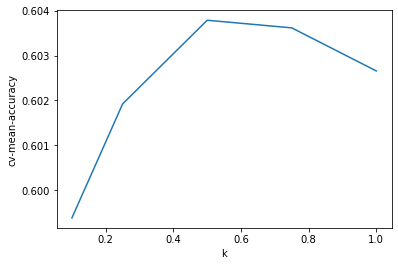

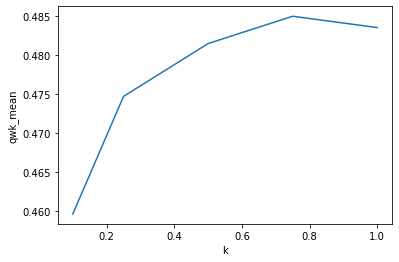

In [90]:
plt.plot(Cs,mean_scores);
plt.xlabel("k");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(Cs,qwks_mean);
plt.xlabel('k');
plt.ylabel('qwk_mean');

# final submit chose C = 0.75
clf = SVC(C = 0.75)
clf.fit(X_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

#submission = {'installation_id': test_users, 'accuracy_group': y_pred}
#sample_submission = pd.DataFrame(submission)
#sample_submission.to_csv('submission.csv', index=False)

This model yielded a score of **0.43** on the private test set

### Tree Classifier <a id='eightc'></a>

Here we try a simple single decision tree

In [ ]:
mean_scores = []
stds = []
qwks_mean = []

depths = [2,4,6,8,10,12,14,16,18,20]

for depth in depths:
    
    cv = KFold(n_splits=10)
    clf = DecisionTreeClassifier(random_state=0,max_depth=depth)

    scores = []
    qwks = []

    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_train,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.fit(X_train_cv, y_train_cv)
        
        scores.append(clf.score(X_test_cv, y_test_cv))
        y_pred = clf.predict(X_test_cv)                
        qwk_res = qwk(y_pred,y_test_cv)                 
        qwks.append(qwk_res)
        
    qwks_mean.append(np.mean(qwks))
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))'''

In [ ]:
plt.plot(depths,mean_scores);
plt.xlabel("depth");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(depths,qwks_mean);
plt.xlabel("depth")
plt.ylabel("qwk")

# final submit chose max_depth = 7
clf = DecisionTreeClassifier(random_state=0,max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)   # do you want feature scaling?

#submission = {'installation_id': test_users, 'accuracy_group': y_pred}
#sample_submission = pd.DataFrame(submission)
#sample_submission.to_csv('submission.csv', index=False)

This model yielded a score of **0.427** on the private test set

### Gradient boosted trees  <a id='eightd'></a>

I was able to achieve a small improvement to about 0.46 with this more complex model. I believe however it overfit the training set and my parameters were not optimal. Also, since I was using regression as the objective, and I didn't have time to build an optimizer, the thresholds are randomly chosen and can have a big effect on the score.

In [94]:
mean_scores = []
stds = []
qwks_mean = []

depths = [4,8,12,16,20,24]

for i in tqdm(range(len(depths))):

    params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'max_depth': depths[i],
    'learning_rate': 0.05,         # maybe reduce this to prevent overfitting?
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
    }
    
    cv = KFold(n_splits=5)

    scores = []
    qwks = []

    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_train,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
        lgb_eval = lgb.Dataset(X_test_cv, y_test_cv, reference=lgb_train)
        
        gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)
        
        y_pred = gbm.predict(X_test_cv, num_iteration=gbm.best_iteration)
        
        #y_pred = np.argmax(y_pred, axis=1)   # use if you are getting probabilities e.g. multi-class

        y_pred[y_pred <= 1.12232214] = 0
        y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
        y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
        y_pred[y_pred > 2.22506454] = 3
        
        scores.append(mean_squared_error(y_test_cv, y_pred)**0.5)
                                 
        qwk_res = qwk(y_pred,y_test_cv)
                                 
        qwks.append(qwk_res)
        
    qwks_mean.append(np.mean(qwks))
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))

[1]	valid_0's l2: 1.5627	valid_0's l1: 1.13213
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 1.52957	valid_0's l1: 1.11952
[3]	valid_0's l2: 1.49732	valid_0's l1: 1.10671
[4]	valid_0's l2: 1.46987	valid_0's l1: 1.09612
[5]	valid_0's l2: 1.44265	valid_0's l1: 1.08527
[6]	valid_0's l2: 1.41925	valid_0's l1: 1.07547
[7]	valid_0's l2: 1.39627	valid_0's l1: 1.06613
[8]	valid_0's l2: 1.37485	valid_0's l1: 1.0574
[9]	valid_0's l2: 1.35515	valid_0's l1: 1.0491
[10]	valid_0's l2: 1.33737	valid_0's l1: 1.04149
[11]	valid_0's l2: 1.31191	valid_0's l1: 1.03048
[12]	valid_0's l2: 1.29891	valid_0's l1: 1.02452
[13]	valid_0's l2: 1.28535	valid_0's l1: 1.01804
[14]	valid_0's l2: 1.27219	valid_0's l1: 1.01147
[15]	valid_0's l2: 1.26145	valid_0's l1: 1.00608
[16]	valid_0's l2: 1.25257	valid_0's l1: 1.00128
[17]	valid_0's l2: 1.24259	valid_0's l1: 0.995755
[18]	valid_0's l2: 1.23216	valid_0's l1: 0.990249
[19]	valid_0's l2: 1.2254	valid_0's l1: 0.986177
[20]	valid_0's l2

[163]	valid_0's l2: 1.03251	valid_0's l1: 0.831489
[164]	valid_0's l2: 1.03282	valid_0's l1: 0.831549
[165]	valid_0's l2: 1.0328	valid_0's l1: 0.831496
[166]	valid_0's l2: 1.03272	valid_0's l1: 0.831545
[167]	valid_0's l2: 1.03247	valid_0's l1: 0.831147
[168]	valid_0's l2: 1.0323	valid_0's l1: 0.830932
[169]	valid_0's l2: 1.03258	valid_0's l1: 0.831057
[170]	valid_0's l2: 1.03257	valid_0's l1: 0.830791
[171]	valid_0's l2: 1.03262	valid_0's l1: 0.830941
[172]	valid_0's l2: 1.03278	valid_0's l1: 0.83109
[173]	valid_0's l2: 1.03293	valid_0's l1: 0.831239
[174]	valid_0's l2: 1.03318	valid_0's l1: 0.831333
[175]	valid_0's l2: 1.03337	valid_0's l1: 0.83132
[176]	valid_0's l2: 1.03326	valid_0's l1: 0.831159
[177]	valid_0's l2: 1.03288	valid_0's l1: 0.83059
[178]	valid_0's l2: 1.03289	valid_0's l1: 0.830485
[179]	valid_0's l2: 1.03273	valid_0's l1: 0.830534
[180]	valid_0's l2: 1.03267	valid_0's l1: 0.830355
[181]	valid_0's l2: 1.03253	valid_0's l1: 0.830352
[182]	valid_0's l2: 1.03235	valid_0'

[324]	valid_0's l2: 1.0313	valid_0's l1: 0.826862
[325]	valid_0's l2: 1.03134	valid_0's l1: 0.826892
[326]	valid_0's l2: 1.03142	valid_0's l1: 0.82685
[327]	valid_0's l2: 1.03131	valid_0's l1: 0.826746
[328]	valid_0's l2: 1.03145	valid_0's l1: 0.82671
[329]	valid_0's l2: 1.03154	valid_0's l1: 0.826744
[330]	valid_0's l2: 1.03145	valid_0's l1: 0.826654
[331]	valid_0's l2: 1.03116	valid_0's l1: 0.826484
[332]	valid_0's l2: 1.0312	valid_0's l1: 0.826505
[333]	valid_0's l2: 1.03122	valid_0's l1: 0.826551
[334]	valid_0's l2: 1.03119	valid_0's l1: 0.826543
[335]	valid_0's l2: 1.03107	valid_0's l1: 0.826438
[336]	valid_0's l2: 1.03122	valid_0's l1: 0.826464
[337]	valid_0's l2: 1.03132	valid_0's l1: 0.826635
[338]	valid_0's l2: 1.03135	valid_0's l1: 0.826739
[339]	valid_0's l2: 1.03146	valid_0's l1: 0.826846
[340]	valid_0's l2: 1.03123	valid_0's l1: 0.826902
[341]	valid_0's l2: 1.03134	valid_0's l1: 0.827106
[342]	valid_0's l2: 1.03151	valid_0's l1: 0.827267
[343]	valid_0's l2: 1.03173	valid_0

[110]	valid_0's l2: 1.01569	valid_0's l1: 0.83566
[111]	valid_0's l2: 1.01574	valid_0's l1: 0.83552
[112]	valid_0's l2: 1.0158	valid_0's l1: 0.835395
[113]	valid_0's l2: 1.01588	valid_0's l1: 0.83539
[114]	valid_0's l2: 1.01577	valid_0's l1: 0.835309
[115]	valid_0's l2: 1.01573	valid_0's l1: 0.835214
[116]	valid_0's l2: 1.0157	valid_0's l1: 0.834937
[117]	valid_0's l2: 1.01593	valid_0's l1: 0.834776
[118]	valid_0's l2: 1.01611	valid_0's l1: 0.834652
[119]	valid_0's l2: 1.01572	valid_0's l1: 0.833995
[120]	valid_0's l2: 1.01567	valid_0's l1: 0.834027
[121]	valid_0's l2: 1.01541	valid_0's l1: 0.833493
[122]	valid_0's l2: 1.01534	valid_0's l1: 0.833263
[123]	valid_0's l2: 1.01511	valid_0's l1: 0.833112
[124]	valid_0's l2: 1.01479	valid_0's l1: 0.832775
[125]	valid_0's l2: 1.01462	valid_0's l1: 0.832338
[126]	valid_0's l2: 1.01447	valid_0's l1: 0.831685
[127]	valid_0's l2: 1.01442	valid_0's l1: 0.831308
[128]	valid_0's l2: 1.0141	valid_0's l1: 0.830696
[129]	valid_0's l2: 1.01376	valid_0's

[13]	valid_0's l2: 1.33679	valid_0's l1: 1.03616
[14]	valid_0's l2: 1.32572	valid_0's l1: 1.03041
[15]	valid_0's l2: 1.31554	valid_0's l1: 1.02526
[16]	valid_0's l2: 1.30734	valid_0's l1: 1.02049
[17]	valid_0's l2: 1.29949	valid_0's l1: 1.01597
[18]	valid_0's l2: 1.29187	valid_0's l1: 1.01144
[19]	valid_0's l2: 1.28513	valid_0's l1: 1.00726
[20]	valid_0's l2: 1.27832	valid_0's l1: 1.00303
[21]	valid_0's l2: 1.27114	valid_0's l1: 0.998812
[22]	valid_0's l2: 1.26669	valid_0's l1: 0.995871
[23]	valid_0's l2: 1.26096	valid_0's l1: 0.992161
[24]	valid_0's l2: 1.25637	valid_0's l1: 0.989006
[25]	valid_0's l2: 1.25189	valid_0's l1: 0.986043
[26]	valid_0's l2: 1.2475	valid_0's l1: 0.982851
[27]	valid_0's l2: 1.243	valid_0's l1: 0.979876
[28]	valid_0's l2: 1.23878	valid_0's l1: 0.977083
[29]	valid_0's l2: 1.23511	valid_0's l1: 0.974428
[30]	valid_0's l2: 1.23219	valid_0's l1: 0.972163
[31]	valid_0's l2: 1.22919	valid_0's l1: 0.969594
[32]	valid_0's l2: 1.22692	valid_0's l1: 0.967405
[33]	valid_

[176]	valid_0's l2: 1.11414	valid_0's l1: 0.868304
[177]	valid_0's l2: 1.11412	valid_0's l1: 0.868165
[178]	valid_0's l2: 1.11411	valid_0's l1: 0.868219
[179]	valid_0's l2: 1.1139	valid_0's l1: 0.868157
[180]	valid_0's l2: 1.11391	valid_0's l1: 0.868149
[181]	valid_0's l2: 1.11378	valid_0's l1: 0.867972
[182]	valid_0's l2: 1.11404	valid_0's l1: 0.867854
[183]	valid_0's l2: 1.11432	valid_0's l1: 0.867799
[184]	valid_0's l2: 1.1144	valid_0's l1: 0.867801
[185]	valid_0's l2: 1.11448	valid_0's l1: 0.867744
[186]	valid_0's l2: 1.11452	valid_0's l1: 0.867753
[187]	valid_0's l2: 1.11446	valid_0's l1: 0.867769
[188]	valid_0's l2: 1.11454	valid_0's l1: 0.867837
[189]	valid_0's l2: 1.11409	valid_0's l1: 0.867729
[190]	valid_0's l2: 1.11418	valid_0's l1: 0.867774
[191]	valid_0's l2: 1.11433	valid_0's l1: 0.86779
[192]	valid_0's l2: 1.11458	valid_0's l1: 0.867915
[193]	valid_0's l2: 1.1146	valid_0's l1: 0.867975
[194]	valid_0's l2: 1.11448	valid_0's l1: 0.867937
[195]	valid_0's l2: 1.11461	valid_0

[94]	valid_0's l2: 1.00787	valid_0's l1: 0.837648
[95]	valid_0's l2: 1.00734	valid_0's l1: 0.837252
[96]	valid_0's l2: 1.00679	valid_0's l1: 0.836574
[97]	valid_0's l2: 1.0066	valid_0's l1: 0.83607
[98]	valid_0's l2: 1.00625	valid_0's l1: 0.835715
[99]	valid_0's l2: 1.00631	valid_0's l1: 0.835544
[100]	valid_0's l2: 1.00564	valid_0's l1: 0.834749
[101]	valid_0's l2: 1.00547	valid_0's l1: 0.834357
[102]	valid_0's l2: 1.00546	valid_0's l1: 0.834256
[103]	valid_0's l2: 1.00543	valid_0's l1: 0.834128
[104]	valid_0's l2: 1.00501	valid_0's l1: 0.833721
[105]	valid_0's l2: 1.00498	valid_0's l1: 0.83371
[106]	valid_0's l2: 1.00471	valid_0's l1: 0.833461
[107]	valid_0's l2: 1.00471	valid_0's l1: 0.833329
[108]	valid_0's l2: 1.00454	valid_0's l1: 0.83317
[109]	valid_0's l2: 1.00436	valid_0's l1: 0.832962
[110]	valid_0's l2: 1.00439	valid_0's l1: 0.832932
[111]	valid_0's l2: 1.00415	valid_0's l1: 0.832596
[112]	valid_0's l2: 1.0041	valid_0's l1: 0.832441
[113]	valid_0's l2: 1.00354	valid_0's l1: 

[253]	valid_0's l2: 0.993864	valid_0's l1: 0.816178
[254]	valid_0's l2: 0.993852	valid_0's l1: 0.816006
[255]	valid_0's l2: 0.993722	valid_0's l1: 0.81576
[256]	valid_0's l2: 0.993549	valid_0's l1: 0.815623
[257]	valid_0's l2: 0.993465	valid_0's l1: 0.815533
[258]	valid_0's l2: 0.993454	valid_0's l1: 0.815504
[259]	valid_0's l2: 0.993437	valid_0's l1: 0.815499
[260]	valid_0's l2: 0.993369	valid_0's l1: 0.815376
[261]	valid_0's l2: 0.99354	valid_0's l1: 0.815374
[262]	valid_0's l2: 0.993669	valid_0's l1: 0.815461
[263]	valid_0's l2: 0.993851	valid_0's l1: 0.815486
[264]	valid_0's l2: 0.993622	valid_0's l1: 0.815404
[265]	valid_0's l2: 0.993683	valid_0's l1: 0.815472
[266]	valid_0's l2: 0.993531	valid_0's l1: 0.815417
[267]	valid_0's l2: 0.993417	valid_0's l1: 0.815395
[268]	valid_0's l2: 0.99351	valid_0's l1: 0.81561
[269]	valid_0's l2: 0.993638	valid_0's l1: 0.815706
[270]	valid_0's l2: 0.993821	valid_0's l1: 0.815818
[271]	valid_0's l2: 0.993956	valid_0's l1: 0.815809
[272]	valid_0's 

[2]	valid_0's l2: 1.52555	valid_0's l1: 1.12903
[3]	valid_0's l2: 1.49683	valid_0's l1: 1.1175
[4]	valid_0's l2: 1.4733	valid_0's l1: 1.10752
[5]	valid_0's l2: 1.44908	valid_0's l1: 1.09734
[6]	valid_0's l2: 1.42899	valid_0's l1: 1.08836
[7]	valid_0's l2: 1.40909	valid_0's l1: 1.07954
[8]	valid_0's l2: 1.39056	valid_0's l1: 1.07129
[9]	valid_0's l2: 1.37381	valid_0's l1: 1.06386
[10]	valid_0's l2: 1.35743	valid_0's l1: 1.05659
[11]	valid_0's l2: 1.33241	valid_0's l1: 1.04599
[12]	valid_0's l2: 1.32077	valid_0's l1: 1.04003
[13]	valid_0's l2: 1.30767	valid_0's l1: 1.03353
[14]	valid_0's l2: 1.29406	valid_0's l1: 1.02657
[15]	valid_0's l2: 1.28267	valid_0's l1: 1.02053
[16]	valid_0's l2: 1.27249	valid_0's l1: 1.01497
[17]	valid_0's l2: 1.26294	valid_0's l1: 1.00993
[18]	valid_0's l2: 1.25417	valid_0's l1: 1.00503
[19]	valid_0's l2: 1.24501	valid_0's l1: 1.00009
[20]	valid_0's l2: 1.2374	valid_0's l1: 0.995693
[21]	valid_0's l2: 1.23	valid_0's l1: 0.991662
[22]	valid_0's l2: 1.22453	valid

[165]	valid_0's l2: 1.03986	valid_0's l1: 0.841878
[166]	valid_0's l2: 1.0398	valid_0's l1: 0.841788
[167]	valid_0's l2: 1.03966	valid_0's l1: 0.841631
[168]	valid_0's l2: 1.03955	valid_0's l1: 0.841491
[169]	valid_0's l2: 1.03941	valid_0's l1: 0.841259
[170]	valid_0's l2: 1.03935	valid_0's l1: 0.841122
[171]	valid_0's l2: 1.03928	valid_0's l1: 0.840891
[172]	valid_0's l2: 1.03935	valid_0's l1: 0.8408
[173]	valid_0's l2: 1.03946	valid_0's l1: 0.840789
[174]	valid_0's l2: 1.03924	valid_0's l1: 0.840481
[175]	valid_0's l2: 1.03926	valid_0's l1: 0.840334
[176]	valid_0's l2: 1.03885	valid_0's l1: 0.840042
[177]	valid_0's l2: 1.03844	valid_0's l1: 0.839669
[178]	valid_0's l2: 1.03807	valid_0's l1: 0.839374
[179]	valid_0's l2: 1.03772	valid_0's l1: 0.83917
[180]	valid_0's l2: 1.03752	valid_0's l1: 0.839129
[181]	valid_0's l2: 1.03769	valid_0's l1: 0.839077
[182]	valid_0's l2: 1.03762	valid_0's l1: 0.839133
[183]	valid_0's l2: 1.03778	valid_0's l1: 0.839133
[184]	valid_0's l2: 1.03771	valid_0

[326]	valid_0's l2: 1.0342	valid_0's l1: 0.8334
[327]	valid_0's l2: 1.03435	valid_0's l1: 0.833532
[328]	valid_0's l2: 1.03447	valid_0's l1: 0.833638
[329]	valid_0's l2: 1.0345	valid_0's l1: 0.833634
[330]	valid_0's l2: 1.03473	valid_0's l1: 0.83377
[331]	valid_0's l2: 1.03456	valid_0's l1: 0.833749
[332]	valid_0's l2: 1.03449	valid_0's l1: 0.833731
[333]	valid_0's l2: 1.03433	valid_0's l1: 0.833658
[334]	valid_0's l2: 1.03444	valid_0's l1: 0.833734
[335]	valid_0's l2: 1.03452	valid_0's l1: 0.833818
[336]	valid_0's l2: 1.03433	valid_0's l1: 0.833723
[337]	valid_0's l2: 1.03417	valid_0's l1: 0.833685
[338]	valid_0's l2: 1.03406	valid_0's l1: 0.833563
[339]	valid_0's l2: 1.03409	valid_0's l1: 0.833586
[340]	valid_0's l2: 1.03415	valid_0's l1: 0.833673
[341]	valid_0's l2: 1.03411	valid_0's l1: 0.833624
[342]	valid_0's l2: 1.03385	valid_0's l1: 0.833509
[343]	valid_0's l2: 1.03404	valid_0's l1: 0.833564
[344]	valid_0's l2: 1.03414	valid_0's l1: 0.833613
[345]	valid_0's l2: 1.03405	valid_0'

[76]	valid_0's l2: 1.02479	valid_0's l1: 0.838491
[77]	valid_0's l2: 1.02467	valid_0's l1: 0.838019
[78]	valid_0's l2: 1.02423	valid_0's l1: 0.837316
[79]	valid_0's l2: 1.02425	valid_0's l1: 0.837295
[80]	valid_0's l2: 1.02377	valid_0's l1: 0.836442
[81]	valid_0's l2: 1.02384	valid_0's l1: 0.835923
[82]	valid_0's l2: 1.02447	valid_0's l1: 0.835849
[83]	valid_0's l2: 1.02503	valid_0's l1: 0.835933
[84]	valid_0's l2: 1.02438	valid_0's l1: 0.835338
[85]	valid_0's l2: 1.02444	valid_0's l1: 0.835337
[86]	valid_0's l2: 1.02478	valid_0's l1: 0.835285
[87]	valid_0's l2: 1.02474	valid_0's l1: 0.834776
[88]	valid_0's l2: 1.02486	valid_0's l1: 0.834845
[89]	valid_0's l2: 1.02544	valid_0's l1: 0.834989
[90]	valid_0's l2: 1.02601	valid_0's l1: 0.835092
[91]	valid_0's l2: 1.02576	valid_0's l1: 0.834819
[92]	valid_0's l2: 1.02529	valid_0's l1: 0.834482
[93]	valid_0's l2: 1.02436	valid_0's l1: 0.833403
[94]	valid_0's l2: 1.02424	valid_0's l1: 0.833434
[95]	valid_0's l2: 1.02317	valid_0's l1: 0.832422


[35]	valid_0's l2: 1.04424	valid_0's l1: 0.879399
[36]	valid_0's l2: 1.04276	valid_0's l1: 0.877545
[37]	valid_0's l2: 1.04099	valid_0's l1: 0.875711
[38]	valid_0's l2: 1.0384	valid_0's l1: 0.872908
[39]	valid_0's l2: 1.03635	valid_0's l1: 0.870941
[40]	valid_0's l2: 1.0348	valid_0's l1: 0.869195
[41]	valid_0's l2: 1.0328	valid_0's l1: 0.86716
[42]	valid_0's l2: 1.03085	valid_0's l1: 0.864886
[43]	valid_0's l2: 1.02856	valid_0's l1: 0.862451
[44]	valid_0's l2: 1.02729	valid_0's l1: 0.860927
[45]	valid_0's l2: 1.02607	valid_0's l1: 0.859334
[46]	valid_0's l2: 1.02479	valid_0's l1: 0.858037
[47]	valid_0's l2: 1.02314	valid_0's l1: 0.856509
[48]	valid_0's l2: 1.02183	valid_0's l1: 0.855066
[49]	valid_0's l2: 1.02023	valid_0's l1: 0.853421
[50]	valid_0's l2: 1.01963	valid_0's l1: 0.852493
[51]	valid_0's l2: 1.01894	valid_0's l1: 0.851407
[52]	valid_0's l2: 1.01857	valid_0's l1: 0.850558
[53]	valid_0's l2: 1.01755	valid_0's l1: 0.849058
[54]	valid_0's l2: 1.01714	valid_0's l1: 0.848165
[55]

[12]	valid_0's l2: 1.28714	valid_0's l1: 1.01829
[13]	valid_0's l2: 1.27493	valid_0's l1: 1.01198
[14]	valid_0's l2: 1.26045	valid_0's l1: 1.00453
[15]	valid_0's l2: 1.24837	valid_0's l1: 0.997902
[16]	valid_0's l2: 1.23784	valid_0's l1: 0.991841
[17]	valid_0's l2: 1.22876	valid_0's l1: 0.986351
[18]	valid_0's l2: 1.21818	valid_0's l1: 0.980041
[19]	valid_0's l2: 1.2082	valid_0's l1: 0.973749
[20]	valid_0's l2: 1.19935	valid_0's l1: 0.967986
[21]	valid_0's l2: 1.19149	valid_0's l1: 0.962707
[22]	valid_0's l2: 1.18464	valid_0's l1: 0.958041
[23]	valid_0's l2: 1.18	valid_0's l1: 0.954443
[24]	valid_0's l2: 1.17485	valid_0's l1: 0.950585
[25]	valid_0's l2: 1.17113	valid_0's l1: 0.947377
[26]	valid_0's l2: 1.16552	valid_0's l1: 0.943034
[27]	valid_0's l2: 1.16228	valid_0's l1: 0.940233
[28]	valid_0's l2: 1.15897	valid_0's l1: 0.93732
[29]	valid_0's l2: 1.15616	valid_0's l1: 0.934574
[30]	valid_0's l2: 1.15349	valid_0's l1: 0.93183
[31]	valid_0's l2: 1.1513	valid_0's l1: 0.929247
[32]	valid

[175]	valid_0's l2: 1.11536	valid_0's l1: 0.860953
[176]	valid_0's l2: 1.11533	valid_0's l1: 0.860812
[177]	valid_0's l2: 1.11525	valid_0's l1: 0.860714
[178]	valid_0's l2: 1.1154	valid_0's l1: 0.860721
[179]	valid_0's l2: 1.11514	valid_0's l1: 0.860522
[180]	valid_0's l2: 1.11507	valid_0's l1: 0.860349
[181]	valid_0's l2: 1.11509	valid_0's l1: 0.860295
[182]	valid_0's l2: 1.11504	valid_0's l1: 0.860309
[183]	valid_0's l2: 1.11509	valid_0's l1: 0.86027
[184]	valid_0's l2: 1.11539	valid_0's l1: 0.860341
[185]	valid_0's l2: 1.11548	valid_0's l1: 0.860389
[186]	valid_0's l2: 1.11571	valid_0's l1: 0.860514
[187]	valid_0's l2: 1.11565	valid_0's l1: 0.860434
[188]	valid_0's l2: 1.1153	valid_0's l1: 0.860225
[189]	valid_0's l2: 1.11526	valid_0's l1: 0.860289
[190]	valid_0's l2: 1.11459	valid_0's l1: 0.859976
[191]	valid_0's l2: 1.11463	valid_0's l1: 0.86002
[192]	valid_0's l2: 1.11467	valid_0's l1: 0.859894
[193]	valid_0's l2: 1.11472	valid_0's l1: 0.859864
[194]	valid_0's l2: 1.1146	valid_0'

[115]	valid_0's l2: 0.991597	valid_0's l1: 0.819411
[116]	valid_0's l2: 0.99144	valid_0's l1: 0.818827
[117]	valid_0's l2: 0.991372	valid_0's l1: 0.818427
[118]	valid_0's l2: 0.991552	valid_0's l1: 0.818534
[119]	valid_0's l2: 0.991375	valid_0's l1: 0.817939
[120]	valid_0's l2: 0.991465	valid_0's l1: 0.817458
[121]	valid_0's l2: 0.991525	valid_0's l1: 0.817411
[122]	valid_0's l2: 0.991773	valid_0's l1: 0.817479
[123]	valid_0's l2: 0.991961	valid_0's l1: 0.817454
[124]	valid_0's l2: 0.991822	valid_0's l1: 0.817277
[125]	valid_0's l2: 0.99208	valid_0's l1: 0.817366
[126]	valid_0's l2: 0.992068	valid_0's l1: 0.817172
[127]	valid_0's l2: 0.992351	valid_0's l1: 0.817154
[128]	valid_0's l2: 0.991842	valid_0's l1: 0.816775
[129]	valid_0's l2: 0.991807	valid_0's l1: 0.816609
[130]	valid_0's l2: 0.991755	valid_0's l1: 0.816437
[131]	valid_0's l2: 0.991817	valid_0's l1: 0.816442
[132]	valid_0's l2: 0.99194	valid_0's l1: 0.81654
[133]	valid_0's l2: 0.991836	valid_0's l1: 0.816407
[134]	valid_0's 

[69]	valid_0's l2: 1.03911	valid_0's l1: 0.851483
[70]	valid_0's l2: 1.03825	valid_0's l1: 0.85034
[71]	valid_0's l2: 1.03854	valid_0's l1: 0.849684
[72]	valid_0's l2: 1.03837	valid_0's l1: 0.848627
[73]	valid_0's l2: 1.03823	valid_0's l1: 0.847983
[74]	valid_0's l2: 1.03746	valid_0's l1: 0.846984
[75]	valid_0's l2: 1.03738	valid_0's l1: 0.846214
[76]	valid_0's l2: 1.03739	valid_0's l1: 0.846002
[77]	valid_0's l2: 1.03734	valid_0's l1: 0.845589
[78]	valid_0's l2: 1.03674	valid_0's l1: 0.845027
[79]	valid_0's l2: 1.0365	valid_0's l1: 0.844772
[80]	valid_0's l2: 1.03721	valid_0's l1: 0.844434
[81]	valid_0's l2: 1.03715	valid_0's l1: 0.844174
[82]	valid_0's l2: 1.03697	valid_0's l1: 0.843911
[83]	valid_0's l2: 1.03661	valid_0's l1: 0.843705
[84]	valid_0's l2: 1.03649	valid_0's l1: 0.843542
[85]	valid_0's l2: 1.03645	valid_0's l1: 0.843316
[86]	valid_0's l2: 1.03591	valid_0's l1: 0.842402
[87]	valid_0's l2: 1.03519	valid_0's l1: 0.841391
[88]	valid_0's l2: 1.03528	valid_0's l1: 0.841221
[8

[230]	valid_0's l2: 1.03301	valid_0's l1: 0.828494
[231]	valid_0's l2: 1.03303	valid_0's l1: 0.82842
[232]	valid_0's l2: 1.03301	valid_0's l1: 0.828295
[233]	valid_0's l2: 1.03305	valid_0's l1: 0.828239
[234]	valid_0's l2: 1.03363	valid_0's l1: 0.828474
[235]	valid_0's l2: 1.03376	valid_0's l1: 0.828487
[236]	valid_0's l2: 1.03383	valid_0's l1: 0.828474
[237]	valid_0's l2: 1.03364	valid_0's l1: 0.828526
[238]	valid_0's l2: 1.0339	valid_0's l1: 0.828662
[239]	valid_0's l2: 1.0339	valid_0's l1: 0.828666
[240]	valid_0's l2: 1.03362	valid_0's l1: 0.828526
[241]	valid_0's l2: 1.03386	valid_0's l1: 0.828599
[242]	valid_0's l2: 1.03403	valid_0's l1: 0.828671
[243]	valid_0's l2: 1.03445	valid_0's l1: 0.828937
[244]	valid_0's l2: 1.03476	valid_0's l1: 0.828944
[245]	valid_0's l2: 1.03502	valid_0's l1: 0.828991
[246]	valid_0's l2: 1.03482	valid_0's l1: 0.8287
[247]	valid_0's l2: 1.03483	valid_0's l1: 0.828621
[248]	valid_0's l2: 1.03484	valid_0's l1: 0.82862
[249]	valid_0's l2: 1.03472	valid_0's

[136]	valid_0's l2: 1.02329	valid_0's l1: 0.827892
[137]	valid_0's l2: 1.0232	valid_0's l1: 0.827915
[138]	valid_0's l2: 1.02355	valid_0's l1: 0.827832
[139]	valid_0's l2: 1.02327	valid_0's l1: 0.827601
[140]	valid_0's l2: 1.02306	valid_0's l1: 0.827536
[141]	valid_0's l2: 1.02307	valid_0's l1: 0.827394
[142]	valid_0's l2: 1.02343	valid_0's l1: 0.827494
[143]	valid_0's l2: 1.02343	valid_0's l1: 0.827428
[144]	valid_0's l2: 1.0236	valid_0's l1: 0.827262
[145]	valid_0's l2: 1.02378	valid_0's l1: 0.827293
[146]	valid_0's l2: 1.0239	valid_0's l1: 0.827435
[147]	valid_0's l2: 1.02352	valid_0's l1: 0.827126
[148]	valid_0's l2: 1.02394	valid_0's l1: 0.827299
[149]	valid_0's l2: 1.02411	valid_0's l1: 0.827507
[150]	valid_0's l2: 1.02401	valid_0's l1: 0.827653
[151]	valid_0's l2: 1.02381	valid_0's l1: 0.827485
[152]	valid_0's l2: 1.02352	valid_0's l1: 0.827188
[153]	valid_0's l2: 1.02307	valid_0's l1: 0.826529
[154]	valid_0's l2: 1.02265	valid_0's l1: 0.826236
[155]	valid_0's l2: 1.02254	valid_

[92]	valid_0's l2: 1.00952	valid_0's l1: 0.826745
[93]	valid_0's l2: 1.00969	valid_0's l1: 0.826706
[94]	valid_0's l2: 1.00929	valid_0's l1: 0.825912
[95]	valid_0's l2: 1.00909	valid_0's l1: 0.82579
[96]	valid_0's l2: 1.00902	valid_0's l1: 0.825606
[97]	valid_0's l2: 1.00895	valid_0's l1: 0.825478
[98]	valid_0's l2: 1.00906	valid_0's l1: 0.825188
[99]	valid_0's l2: 1.00893	valid_0's l1: 0.824955
[100]	valid_0's l2: 1.00912	valid_0's l1: 0.824744
[101]	valid_0's l2: 1.00909	valid_0's l1: 0.824665
[102]	valid_0's l2: 1.00892	valid_0's l1: 0.824582
[103]	valid_0's l2: 1.00873	valid_0's l1: 0.824411
[104]	valid_0's l2: 1.0085	valid_0's l1: 0.823923
[105]	valid_0's l2: 1.00878	valid_0's l1: 0.823806
[106]	valid_0's l2: 1.00856	valid_0's l1: 0.823272
[107]	valid_0's l2: 1.0087	valid_0's l1: 0.822817
[108]	valid_0's l2: 1.00884	valid_0's l1: 0.822851
[109]	valid_0's l2: 1.00907	valid_0's l1: 0.82288
[110]	valid_0's l2: 1.00899	valid_0's l1: 0.822761
[111]	valid_0's l2: 1.00921	valid_0's l1: 0

[47]	valid_0's l2: 1.12764	valid_0's l1: 0.897772
[48]	valid_0's l2: 1.12694	valid_0's l1: 0.896837
[49]	valid_0's l2: 1.12717	valid_0's l1: 0.896027
[50]	valid_0's l2: 1.12631	valid_0's l1: 0.894827
[51]	valid_0's l2: 1.12607	valid_0's l1: 0.894043
[52]	valid_0's l2: 1.12591	valid_0's l1: 0.893297
[53]	valid_0's l2: 1.12489	valid_0's l1: 0.891789
[54]	valid_0's l2: 1.12478	valid_0's l1: 0.891004
[55]	valid_0's l2: 1.12386	valid_0's l1: 0.890084
[56]	valid_0's l2: 1.12327	valid_0's l1: 0.88881
[57]	valid_0's l2: 1.12208	valid_0's l1: 0.887204
[58]	valid_0's l2: 1.12133	valid_0's l1: 0.885842
[59]	valid_0's l2: 1.12081	valid_0's l1: 0.884675
[60]	valid_0's l2: 1.12085	valid_0's l1: 0.884285
[61]	valid_0's l2: 1.12035	valid_0's l1: 0.883803
[62]	valid_0's l2: 1.11959	valid_0's l1: 0.882988
[63]	valid_0's l2: 1.11961	valid_0's l1: 0.882555
[64]	valid_0's l2: 1.11946	valid_0's l1: 0.882031
[65]	valid_0's l2: 1.11924	valid_0's l1: 0.881434
[66]	valid_0's l2: 1.11899	valid_0's l1: 0.880675
[

[3]	valid_0's l2: 1.41729	valid_0's l1: 1.08726
[4]	valid_0's l2: 1.38614	valid_0's l1: 1.07362
[5]	valid_0's l2: 1.35813	valid_0's l1: 1.06176
[6]	valid_0's l2: 1.3275	valid_0's l1: 1.04863
[7]	valid_0's l2: 1.30019	valid_0's l1: 1.03675
[8]	valid_0's l2: 1.28014	valid_0's l1: 1.02794
[9]	valid_0's l2: 1.26117	valid_0's l1: 1.01942
[10]	valid_0's l2: 1.23905	valid_0's l1: 1.00907
[11]	valid_0's l2: 1.21811	valid_0's l1: 0.99894
[12]	valid_0's l2: 1.19986	valid_0's l1: 0.989901
[13]	valid_0's l2: 1.18638	valid_0's l1: 0.98279
[14]	valid_0's l2: 1.17045	valid_0's l1: 0.974103
[15]	valid_0's l2: 1.1567	valid_0's l1: 0.966252
[16]	valid_0's l2: 1.14339	valid_0's l1: 0.958687
[17]	valid_0's l2: 1.13353	valid_0's l1: 0.952506
[18]	valid_0's l2: 1.12277	valid_0's l1: 0.945949
[19]	valid_0's l2: 1.11236	valid_0's l1: 0.939554
[20]	valid_0's l2: 1.10293	valid_0's l1: 0.933573
[21]	valid_0's l2: 1.09501	valid_0's l1: 0.928384
[22]	valid_0's l2: 1.08903	valid_0's l1: 0.924511
[23]	valid_0's l2: 

[164]	valid_0's l2: 0.988898	valid_0's l1: 0.813194
[165]	valid_0's l2: 0.989029	valid_0's l1: 0.813284
[166]	valid_0's l2: 0.989128	valid_0's l1: 0.813291
[167]	valid_0's l2: 0.989137	valid_0's l1: 0.813204
[168]	valid_0's l2: 0.988881	valid_0's l1: 0.813078
[169]	valid_0's l2: 0.989062	valid_0's l1: 0.81299
[170]	valid_0's l2: 0.989119	valid_0's l1: 0.812975
[171]	valid_0's l2: 0.98894	valid_0's l1: 0.812941
[172]	valid_0's l2: 0.989163	valid_0's l1: 0.812982
[173]	valid_0's l2: 0.989355	valid_0's l1: 0.812993
[174]	valid_0's l2: 0.988778	valid_0's l1: 0.812778
[175]	valid_0's l2: 0.98908	valid_0's l1: 0.812763
[176]	valid_0's l2: 0.988931	valid_0's l1: 0.812727
[177]	valid_0's l2: 0.988824	valid_0's l1: 0.812716
[178]	valid_0's l2: 0.988443	valid_0's l1: 0.812464
[179]	valid_0's l2: 0.988373	valid_0's l1: 0.812346
[180]	valid_0's l2: 0.988444	valid_0's l1: 0.812463
[181]	valid_0's l2: 0.988417	valid_0's l1: 0.812505
[182]	valid_0's l2: 0.988446	valid_0's l1: 0.812556
[183]	valid_0's

[114]	valid_0's l2: 1.0251	valid_0's l1: 0.83238
[115]	valid_0's l2: 1.025	valid_0's l1: 0.832307
[116]	valid_0's l2: 1.02487	valid_0's l1: 0.831793
[117]	valid_0's l2: 1.02495	valid_0's l1: 0.831586
[118]	valid_0's l2: 1.02453	valid_0's l1: 0.831355
[119]	valid_0's l2: 1.02462	valid_0's l1: 0.831434
[120]	valid_0's l2: 1.02463	valid_0's l1: 0.831116
[121]	valid_0's l2: 1.02449	valid_0's l1: 0.830989
[122]	valid_0's l2: 1.02452	valid_0's l1: 0.830978
[123]	valid_0's l2: 1.02452	valid_0's l1: 0.830907
[124]	valid_0's l2: 1.02432	valid_0's l1: 0.830936
[125]	valid_0's l2: 1.02424	valid_0's l1: 0.830906
[126]	valid_0's l2: 1.02405	valid_0's l1: 0.830835
[127]	valid_0's l2: 1.02437	valid_0's l1: 0.830933
[128]	valid_0's l2: 1.02406	valid_0's l1: 0.830654
[129]	valid_0's l2: 1.0243	valid_0's l1: 0.830724
[130]	valid_0's l2: 1.02424	valid_0's l1: 0.830581
[131]	valid_0's l2: 1.02424	valid_0's l1: 0.83074
[132]	valid_0's l2: 1.02422	valid_0's l1: 0.830934
[133]	valid_0's l2: 1.02449	valid_0's

[18]	valid_0's l2: 1.16371	valid_0's l1: 0.959513
[19]	valid_0's l2: 1.15436	valid_0's l1: 0.953346
[20]	valid_0's l2: 1.14639	valid_0's l1: 0.948309
[21]	valid_0's l2: 1.13705	valid_0's l1: 0.942036
[22]	valid_0's l2: 1.13101	valid_0's l1: 0.93764
[23]	valid_0's l2: 1.12488	valid_0's l1: 0.933263
[24]	valid_0's l2: 1.11957	valid_0's l1: 0.929486
[25]	valid_0's l2: 1.11387	valid_0's l1: 0.925389
[26]	valid_0's l2: 1.10722	valid_0's l1: 0.920655
[27]	valid_0's l2: 1.10133	valid_0's l1: 0.916228
[28]	valid_0's l2: 1.0962	valid_0's l1: 0.912171
[29]	valid_0's l2: 1.0908	valid_0's l1: 0.907977
[30]	valid_0's l2: 1.08606	valid_0's l1: 0.904171
[31]	valid_0's l2: 1.08316	valid_0's l1: 0.901368
[32]	valid_0's l2: 1.07964	valid_0's l1: 0.898289
[33]	valid_0's l2: 1.07666	valid_0's l1: 0.89559
[34]	valid_0's l2: 1.07484	valid_0's l1: 0.893497
[35]	valid_0's l2: 1.07109	valid_0's l1: 0.890116
[36]	valid_0's l2: 1.06979	valid_0's l1: 0.888629
[37]	valid_0's l2: 1.06842	valid_0's l1: 0.886988
[38]

[181]	valid_0's l2: 1.03337	valid_0's l1: 0.829343
[182]	valid_0's l2: 1.03328	valid_0's l1: 0.829074
[183]	valid_0's l2: 1.03332	valid_0's l1: 0.829084
[184]	valid_0's l2: 1.034	valid_0's l1: 0.82943
[185]	valid_0's l2: 1.03389	valid_0's l1: 0.829274
[186]	valid_0's l2: 1.03428	valid_0's l1: 0.829345
[187]	valid_0's l2: 1.03487	valid_0's l1: 0.829509
[188]	valid_0's l2: 1.03523	valid_0's l1: 0.829516
[189]	valid_0's l2: 1.03558	valid_0's l1: 0.829557
[190]	valid_0's l2: 1.03579	valid_0's l1: 0.829716
[191]	valid_0's l2: 1.03597	valid_0's l1: 0.829873
[192]	valid_0's l2: 1.03643	valid_0's l1: 0.830012
[193]	valid_0's l2: 1.0364	valid_0's l1: 0.829944
[194]	valid_0's l2: 1.03645	valid_0's l1: 0.829886
[195]	valid_0's l2: 1.03642	valid_0's l1: 0.829785
[196]	valid_0's l2: 1.03623	valid_0's l1: 0.82958
[197]	valid_0's l2: 1.03625	valid_0's l1: 0.829704
[198]	valid_0's l2: 1.03641	valid_0's l1: 0.829693
[199]	valid_0's l2: 1.03673	valid_0's l1: 0.829982
[200]	valid_0's l2: 1.03705	valid_0'

[139]	valid_0's l2: 1.01291	valid_0's l1: 0.824342
[140]	valid_0's l2: 1.01284	valid_0's l1: 0.824284
[141]	valid_0's l2: 1.01304	valid_0's l1: 0.824291
[142]	valid_0's l2: 1.01318	valid_0's l1: 0.824331
[143]	valid_0's l2: 1.01321	valid_0's l1: 0.824265
[144]	valid_0's l2: 1.01342	valid_0's l1: 0.824267
[145]	valid_0's l2: 1.013	valid_0's l1: 0.824108
[146]	valid_0's l2: 1.01308	valid_0's l1: 0.824144
[147]	valid_0's l2: 1.0132	valid_0's l1: 0.824115
[148]	valid_0's l2: 1.01319	valid_0's l1: 0.823993
[149]	valid_0's l2: 1.01341	valid_0's l1: 0.823869
[150]	valid_0's l2: 1.01359	valid_0's l1: 0.823877
[151]	valid_0's l2: 1.01362	valid_0's l1: 0.824054
[152]	valid_0's l2: 1.01346	valid_0's l1: 0.823877
[153]	valid_0's l2: 1.01354	valid_0's l1: 0.823782
[154]	valid_0's l2: 1.01367	valid_0's l1: 0.823898
[155]	valid_0's l2: 1.01336	valid_0's l1: 0.82366
[156]	valid_0's l2: 1.01378	valid_0's l1: 0.823983
[157]	valid_0's l2: 1.01428	valid_0's l1: 0.824174
[158]	valid_0's l2: 1.01465	valid_0

[120]	valid_0's l2: 1.11774	valid_0's l1: 0.867161
[121]	valid_0's l2: 1.11781	valid_0's l1: 0.866867
[122]	valid_0's l2: 1.1179	valid_0's l1: 0.86678
[123]	valid_0's l2: 1.1181	valid_0's l1: 0.866626
[124]	valid_0's l2: 1.1184	valid_0's l1: 0.866594
[125]	valid_0's l2: 1.11855	valid_0's l1: 0.866499
[126]	valid_0's l2: 1.11832	valid_0's l1: 0.866019
[127]	valid_0's l2: 1.11845	valid_0's l1: 0.865832
[128]	valid_0's l2: 1.11838	valid_0's l1: 0.865635
[129]	valid_0's l2: 1.11819	valid_0's l1: 0.865367
[130]	valid_0's l2: 1.1183	valid_0's l1: 0.865128
[131]	valid_0's l2: 1.11803	valid_0's l1: 0.865107
[132]	valid_0's l2: 1.11796	valid_0's l1: 0.865176
[133]	valid_0's l2: 1.11757	valid_0's l1: 0.865062
[134]	valid_0's l2: 1.1175	valid_0's l1: 0.86503
[135]	valid_0's l2: 1.11744	valid_0's l1: 0.865137
[136]	valid_0's l2: 1.11728	valid_0's l1: 0.865105
[137]	valid_0's l2: 1.11775	valid_0's l1: 0.865099
[138]	valid_0's l2: 1.11779	valid_0's l1: 0.865057
[139]	valid_0's l2: 1.11766	valid_0's 

[94]	valid_0's l2: 0.98944	valid_0's l1: 0.820785
[95]	valid_0's l2: 0.988937	valid_0's l1: 0.820317
[96]	valid_0's l2: 0.989305	valid_0's l1: 0.820276
[97]	valid_0's l2: 0.989526	valid_0's l1: 0.820139
[98]	valid_0's l2: 0.9897	valid_0's l1: 0.819992
[99]	valid_0's l2: 0.989537	valid_0's l1: 0.819528
[100]	valid_0's l2: 0.989359	valid_0's l1: 0.819006
[101]	valid_0's l2: 0.989314	valid_0's l1: 0.819057
[102]	valid_0's l2: 0.988863	valid_0's l1: 0.818872
[103]	valid_0's l2: 0.988762	valid_0's l1: 0.818919
[104]	valid_0's l2: 0.988827	valid_0's l1: 0.818862
[105]	valid_0's l2: 0.988531	valid_0's l1: 0.818703
[106]	valid_0's l2: 0.988292	valid_0's l1: 0.818238
[107]	valid_0's l2: 0.988239	valid_0's l1: 0.818175
[108]	valid_0's l2: 0.988613	valid_0's l1: 0.818383
[109]	valid_0's l2: 0.988364	valid_0's l1: 0.818183
[110]	valid_0's l2: 0.988785	valid_0's l1: 0.818408
[111]	valid_0's l2: 0.988733	valid_0's l1: 0.818401
[112]	valid_0's l2: 0.988569	valid_0's l1: 0.81818
[113]	valid_0's l2: 0.

[44]	valid_0's l2: 1.06082	valid_0's l1: 0.881522
[45]	valid_0's l2: 1.06029	valid_0's l1: 0.880091
[46]	valid_0's l2: 1.05932	valid_0's l1: 0.878878
[47]	valid_0's l2: 1.05695	valid_0's l1: 0.876604
[48]	valid_0's l2: 1.0555	valid_0's l1: 0.874868
[49]	valid_0's l2: 1.05437	valid_0's l1: 0.873369
[50]	valid_0's l2: 1.05375	valid_0's l1: 0.872158
[51]	valid_0's l2: 1.05236	valid_0's l1: 0.870842
[52]	valid_0's l2: 1.05171	valid_0's l1: 0.869866
[53]	valid_0's l2: 1.04971	valid_0's l1: 0.867671
[54]	valid_0's l2: 1.04895	valid_0's l1: 0.866599
[55]	valid_0's l2: 1.04769	valid_0's l1: 0.865206
[56]	valid_0's l2: 1.04603	valid_0's l1: 0.863355
[57]	valid_0's l2: 1.04479	valid_0's l1: 0.86189
[58]	valid_0's l2: 1.04311	valid_0's l1: 0.860096
[59]	valid_0's l2: 1.04184	valid_0's l1: 0.858654
[60]	valid_0's l2: 1.04159	valid_0's l1: 0.858
[61]	valid_0's l2: 1.0413	valid_0's l1: 0.857611
[62]	valid_0's l2: 1.04023	valid_0's l1: 0.856272
[63]	valid_0's l2: 1.03952	valid_0's l1: 0.855506
[64]	v

[206]	valid_0's l2: 1.02972	valid_0's l1: 0.830242
[207]	valid_0's l2: 1.02987	valid_0's l1: 0.8302
[208]	valid_0's l2: 1.0302	valid_0's l1: 0.830437
[209]	valid_0's l2: 1.03038	valid_0's l1: 0.83044
[210]	valid_0's l2: 1.03057	valid_0's l1: 0.830538
[211]	valid_0's l2: 1.03048	valid_0's l1: 0.830433
[212]	valid_0's l2: 1.03011	valid_0's l1: 0.830009
[213]	valid_0's l2: 1.02962	valid_0's l1: 0.829721
[214]	valid_0's l2: 1.0294	valid_0's l1: 0.829551
[215]	valid_0's l2: 1.02919	valid_0's l1: 0.829515
[216]	valid_0's l2: 1.02876	valid_0's l1: 0.829343
[217]	valid_0's l2: 1.02869	valid_0's l1: 0.829293
[218]	valid_0's l2: 1.02863	valid_0's l1: 0.829206
[219]	valid_0's l2: 1.02868	valid_0's l1: 0.829229
[220]	valid_0's l2: 1.02888	valid_0's l1: 0.829421
[221]	valid_0's l2: 1.0289	valid_0's l1: 0.829469
[222]	valid_0's l2: 1.02885	valid_0's l1: 0.829359
[223]	valid_0's l2: 1.02866	valid_0's l1: 0.829283
[224]	valid_0's l2: 1.02849	valid_0's l1: 0.829227
[225]	valid_0's l2: 1.02853	valid_0's

[109]	valid_0's l2: 1.0241	valid_0's l1: 0.831078
[110]	valid_0's l2: 1.02395	valid_0's l1: 0.83111
[111]	valid_0's l2: 1.02407	valid_0's l1: 0.830859
[112]	valid_0's l2: 1.02394	valid_0's l1: 0.830622
[113]	valid_0's l2: 1.02385	valid_0's l1: 0.830426
[114]	valid_0's l2: 1.02423	valid_0's l1: 0.830553
[115]	valid_0's l2: 1.02444	valid_0's l1: 0.830571
[116]	valid_0's l2: 1.02432	valid_0's l1: 0.83037
[117]	valid_0's l2: 1.02455	valid_0's l1: 0.830318
[118]	valid_0's l2: 1.02452	valid_0's l1: 0.830267
[119]	valid_0's l2: 1.02472	valid_0's l1: 0.830232
[120]	valid_0's l2: 1.02464	valid_0's l1: 0.830157
[121]	valid_0's l2: 1.02472	valid_0's l1: 0.82996
[122]	valid_0's l2: 1.02509	valid_0's l1: 0.830055
[123]	valid_0's l2: 1.0259	valid_0's l1: 0.830387
[124]	valid_0's l2: 1.02577	valid_0's l1: 0.8302
[125]	valid_0's l2: 1.02635	valid_0's l1: 0.830444
[126]	valid_0's l2: 1.0264	valid_0's l1: 0.830496
[127]	valid_0's l2: 1.02628	valid_0's l1: 0.830464
[128]	valid_0's l2: 1.02624	valid_0's l

[67]	valid_0's l2: 1.01321	valid_0's l1: 0.837975
[68]	valid_0's l2: 1.01281	valid_0's l1: 0.837662
[69]	valid_0's l2: 1.01296	valid_0's l1: 0.837528
[70]	valid_0's l2: 1.01278	valid_0's l1: 0.837289
[71]	valid_0's l2: 1.01248	valid_0's l1: 0.836428
[72]	valid_0's l2: 1.01214	valid_0's l1: 0.835478
[73]	valid_0's l2: 1.01164	valid_0's l1: 0.834997
[74]	valid_0's l2: 1.01125	valid_0's l1: 0.834158
[75]	valid_0's l2: 1.01086	valid_0's l1: 0.833339
[76]	valid_0's l2: 1.01093	valid_0's l1: 0.833131
[77]	valid_0's l2: 1.01069	valid_0's l1: 0.832825
[78]	valid_0's l2: 1.01037	valid_0's l1: 0.832225
[79]	valid_0's l2: 1.01018	valid_0's l1: 0.831927
[80]	valid_0's l2: 1.01021	valid_0's l1: 0.831684
[81]	valid_0's l2: 1.01052	valid_0's l1: 0.831789
[82]	valid_0's l2: 1.01046	valid_0's l1: 0.831663
[83]	valid_0's l2: 1.01049	valid_0's l1: 0.831344
[84]	valid_0's l2: 1.0105	valid_0's l1: 0.831319
[85]	valid_0's l2: 1.01041	valid_0's l1: 0.830528
[86]	valid_0's l2: 1.01035	valid_0's l1: 0.829947
[

[48]	valid_0's l2: 1.12689	valid_0's l1: 0.896584
[49]	valid_0's l2: 1.1262	valid_0's l1: 0.895667
[50]	valid_0's l2: 1.12583	valid_0's l1: 0.894942
[51]	valid_0's l2: 1.12492	valid_0's l1: 0.893945
[52]	valid_0's l2: 1.12471	valid_0's l1: 0.893066
[53]	valid_0's l2: 1.12357	valid_0's l1: 0.891457
[54]	valid_0's l2: 1.12334	valid_0's l1: 0.890844
[55]	valid_0's l2: 1.12244	valid_0's l1: 0.889891
[56]	valid_0's l2: 1.12197	valid_0's l1: 0.888577
[57]	valid_0's l2: 1.12119	valid_0's l1: 0.887221
[58]	valid_0's l2: 1.12031	valid_0's l1: 0.885794
[59]	valid_0's l2: 1.11957	valid_0's l1: 0.884647
[60]	valid_0's l2: 1.11954	valid_0's l1: 0.884183
[61]	valid_0's l2: 1.11886	valid_0's l1: 0.883732
[62]	valid_0's l2: 1.11858	valid_0's l1: 0.883363
[63]	valid_0's l2: 1.11843	valid_0's l1: 0.882806
[64]	valid_0's l2: 1.11821	valid_0's l1: 0.882184
[65]	valid_0's l2: 1.11767	valid_0's l1: 0.881446
[66]	valid_0's l2: 1.1171	valid_0's l1: 0.880468
[67]	valid_0's l2: 1.11673	valid_0's l1: 0.880093
[6

[23]	valid_0's l2: 1.08306	valid_0's l1: 0.92041
[24]	valid_0's l2: 1.07758	valid_0's l1: 0.916654
[25]	valid_0's l2: 1.07289	valid_0's l1: 0.913131
[26]	valid_0's l2: 1.06609	valid_0's l1: 0.908178
[27]	valid_0's l2: 1.06088	valid_0's l1: 0.904175
[28]	valid_0's l2: 1.05583	valid_0's l1: 0.900112
[29]	valid_0's l2: 1.05102	valid_0's l1: 0.896213
[30]	valid_0's l2: 1.0469	valid_0's l1: 0.892763
[31]	valid_0's l2: 1.04368	valid_0's l1: 0.889837
[32]	valid_0's l2: 1.04074	valid_0's l1: 0.887082
[33]	valid_0's l2: 1.03812	valid_0's l1: 0.88468
[34]	valid_0's l2: 1.03592	valid_0's l1: 0.882391
[35]	valid_0's l2: 1.03255	valid_0's l1: 0.879093
[36]	valid_0's l2: 1.03022	valid_0's l1: 0.876836
[37]	valid_0's l2: 1.0283	valid_0's l1: 0.874907
[38]	valid_0's l2: 1.02494	valid_0's l1: 0.871649
[39]	valid_0's l2: 1.02268	valid_0's l1: 0.86914
[40]	valid_0's l2: 1.02115	valid_0's l1: 0.867259
[41]	valid_0's l2: 1.01952	valid_0's l1: 0.865223
[42]	valid_0's l2: 1.01794	valid_0's l1: 0.863149
[43]	

[183]	valid_0's l2: 0.991189	valid_0's l1: 0.812467
[184]	valid_0's l2: 0.991035	valid_0's l1: 0.812339
[185]	valid_0's l2: 0.991081	valid_0's l1: 0.812262
[186]	valid_0's l2: 0.990894	valid_0's l1: 0.81211
[187]	valid_0's l2: 0.990974	valid_0's l1: 0.812124
[188]	valid_0's l2: 0.991292	valid_0's l1: 0.812248
[189]	valid_0's l2: 0.991075	valid_0's l1: 0.81211
[190]	valid_0's l2: 0.991074	valid_0's l1: 0.812064
[191]	valid_0's l2: 0.990931	valid_0's l1: 0.812067
[192]	valid_0's l2: 0.991019	valid_0's l1: 0.812074
[193]	valid_0's l2: 0.990848	valid_0's l1: 0.812077
[194]	valid_0's l2: 0.990916	valid_0's l1: 0.81212
[195]	valid_0's l2: 0.991031	valid_0's l1: 0.812303
[196]	valid_0's l2: 0.991219	valid_0's l1: 0.81246
[197]	valid_0's l2: 0.991275	valid_0's l1: 0.812528
[198]	valid_0's l2: 0.991491	valid_0's l1: 0.812715
[199]	valid_0's l2: 0.991311	valid_0's l1: 0.812596
[200]	valid_0's l2: 0.991249	valid_0's l1: 0.812589
[201]	valid_0's l2: 0.991685	valid_0's l1: 0.812675
[202]	valid_0's 

[124]	valid_0's l2: 1.02831	valid_0's l1: 0.83242
[125]	valid_0's l2: 1.02825	valid_0's l1: 0.832167
[126]	valid_0's l2: 1.02876	valid_0's l1: 0.832352
[127]	valid_0's l2: 1.02847	valid_0's l1: 0.832127
[128]	valid_0's l2: 1.02847	valid_0's l1: 0.832108
[129]	valid_0's l2: 1.02859	valid_0's l1: 0.831994
[130]	valid_0's l2: 1.0286	valid_0's l1: 0.831702
[131]	valid_0's l2: 1.02836	valid_0's l1: 0.831717
[132]	valid_0's l2: 1.02869	valid_0's l1: 0.831826
[133]	valid_0's l2: 1.02885	valid_0's l1: 0.832148
[134]	valid_0's l2: 1.02895	valid_0's l1: 0.832251
[135]	valid_0's l2: 1.0289	valid_0's l1: 0.832328
[136]	valid_0's l2: 1.02906	valid_0's l1: 0.832588
[137]	valid_0's l2: 1.02924	valid_0's l1: 0.832755
[138]	valid_0's l2: 1.02936	valid_0's l1: 0.832984
[139]	valid_0's l2: 1.02948	valid_0's l1: 0.833064
[140]	valid_0's l2: 1.03002	valid_0's l1: 0.833326
[141]	valid_0's l2: 1.02992	valid_0's l1: 0.833176
[142]	valid_0's l2: 1.03004	valid_0's l1: 0.83315
[143]	valid_0's l2: 1.02952	valid_0

[62]	valid_0's l2: 1.03277	valid_0's l1: 0.848291
[63]	valid_0's l2: 1.03276	valid_0's l1: 0.848116
[64]	valid_0's l2: 1.03259	valid_0's l1: 0.847714
[65]	valid_0's l2: 1.03239	valid_0's l1: 0.84732
[66]	valid_0's l2: 1.03217	valid_0's l1: 0.846993
[67]	valid_0's l2: 1.03194	valid_0's l1: 0.846524
[68]	valid_0's l2: 1.03183	valid_0's l1: 0.846399
[69]	valid_0's l2: 1.03134	valid_0's l1: 0.845568
[70]	valid_0's l2: 1.03128	valid_0's l1: 0.845453
[71]	valid_0's l2: 1.03102	valid_0's l1: 0.844478
[72]	valid_0's l2: 1.03042	valid_0's l1: 0.843375
[73]	valid_0's l2: 1.02948	valid_0's l1: 0.842558
[74]	valid_0's l2: 1.02853	valid_0's l1: 0.841523
[75]	valid_0's l2: 1.02786	valid_0's l1: 0.840419
[76]	valid_0's l2: 1.02773	valid_0's l1: 0.840038
[77]	valid_0's l2: 1.02711	valid_0's l1: 0.839615
[78]	valid_0's l2: 1.02644	valid_0's l1: 0.838701
[79]	valid_0's l2: 1.02609	valid_0's l1: 0.838554
[80]	valid_0's l2: 1.02635	valid_0's l1: 0.83849
[81]	valid_0's l2: 1.02549	valid_0's l1: 0.837889
[8

[20]	valid_0's l2: 1.11699	valid_0's l1: 0.936328
[21]	valid_0's l2: 1.10767	valid_0's l1: 0.930497
[22]	valid_0's l2: 1.09939	valid_0's l1: 0.925152
[23]	valid_0's l2: 1.093	valid_0's l1: 0.9208
[24]	valid_0's l2: 1.086	valid_0's l1: 0.915842
[25]	valid_0's l2: 1.08065	valid_0's l1: 0.912107
[26]	valid_0's l2: 1.07447	valid_0's l1: 0.90753
[27]	valid_0's l2: 1.06927	valid_0's l1: 0.903476
[28]	valid_0's l2: 1.06425	valid_0's l1: 0.899325
[29]	valid_0's l2: 1.06036	valid_0's l1: 0.895973
[30]	valid_0's l2: 1.05665	valid_0's l1: 0.892531
[31]	valid_0's l2: 1.05284	valid_0's l1: 0.889023
[32]	valid_0's l2: 1.04995	valid_0's l1: 0.885861
[33]	valid_0's l2: 1.0471	valid_0's l1: 0.883075
[34]	valid_0's l2: 1.04543	valid_0's l1: 0.881055
[35]	valid_0's l2: 1.0421	valid_0's l1: 0.877831
[36]	valid_0's l2: 1.04027	valid_0's l1: 0.875991
[37]	valid_0's l2: 1.03838	valid_0's l1: 0.874146
[38]	valid_0's l2: 1.03614	valid_0's l1: 0.871523
[39]	valid_0's l2: 1.03439	valid_0's l1: 0.869121
[40]	vali

Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 1.52542	valid_0's l1: 1.11611
[3]	valid_0's l2: 1.49297	valid_0's l1: 1.10306
[4]	valid_0's l2: 1.46253	valid_0's l1: 1.09151
[5]	valid_0's l2: 1.43605	valid_0's l1: 1.08086
[6]	valid_0's l2: 1.40639	valid_0's l1: 1.0694
[7]	valid_0's l2: 1.38071	valid_0's l1: 1.05934
[8]	valid_0's l2: 1.36157	valid_0's l1: 1.05164
[9]	valid_0's l2: 1.34377	valid_0's l1: 1.04397
[10]	valid_0's l2: 1.32319	valid_0's l1: 1.03501
[11]	valid_0's l2: 1.30291	valid_0's l1: 1.02592
[12]	valid_0's l2: 1.28629	valid_0's l1: 1.01795
[13]	valid_0's l2: 1.2739	valid_0's l1: 1.01163
[14]	valid_0's l2: 1.25996	valid_0's l1: 1.00435
[15]	valid_0's l2: 1.24774	valid_0's l1: 0.997693
[16]	valid_0's l2: 1.23725	valid_0's l1: 0.991768
[17]	valid_0's l2: 1.22791	valid_0's l1: 0.986155
[18]	valid_0's l2: 1.2178	valid_0's l1: 0.980099
[19]	valid_0's l2: 1.20806	valid_0's l1: 0.974026
[20]	valid_0's l2: 1.20159	valid_0's l1: 0.969413
[21]	valid_0

[164]	valid_0's l2: 1.1236	valid_0's l1: 0.866067
[165]	valid_0's l2: 1.1233	valid_0's l1: 0.865852
[166]	valid_0's l2: 1.12338	valid_0's l1: 0.865757
[167]	valid_0's l2: 1.12356	valid_0's l1: 0.865807
[168]	valid_0's l2: 1.12373	valid_0's l1: 0.865818
[169]	valid_0's l2: 1.12396	valid_0's l1: 0.865732
[170]	valid_0's l2: 1.12406	valid_0's l1: 0.865729
[171]	valid_0's l2: 1.12391	valid_0's l1: 0.865643
[172]	valid_0's l2: 1.1241	valid_0's l1: 0.865944
[173]	valid_0's l2: 1.12408	valid_0's l1: 0.865905
[174]	valid_0's l2: 1.12387	valid_0's l1: 0.865794
[175]	valid_0's l2: 1.12408	valid_0's l1: 0.865795
[176]	valid_0's l2: 1.12371	valid_0's l1: 0.865476
[177]	valid_0's l2: 1.1236	valid_0's l1: 0.865304
[178]	valid_0's l2: 1.12347	valid_0's l1: 0.865159
[179]	valid_0's l2: 1.12344	valid_0's l1: 0.865016
[180]	valid_0's l2: 1.12332	valid_0's l1: 0.864848
[181]	valid_0's l2: 1.12346	valid_0's l1: 0.864816
[182]	valid_0's l2: 1.1235	valid_0's l1: 0.864744
[183]	valid_0's l2: 1.12335	valid_0'

[138]	valid_0's l2: 0.990613	valid_0's l1: 0.815344
[139]	valid_0's l2: 0.990538	valid_0's l1: 0.815261
[140]	valid_0's l2: 0.990172	valid_0's l1: 0.815096
[141]	valid_0's l2: 0.990689	valid_0's l1: 0.81523
[142]	valid_0's l2: 0.990742	valid_0's l1: 0.815243
[143]	valid_0's l2: 0.991076	valid_0's l1: 0.815359
[144]	valid_0's l2: 0.990899	valid_0's l1: 0.815227
[145]	valid_0's l2: 0.990766	valid_0's l1: 0.815139
[146]	valid_0's l2: 0.990644	valid_0's l1: 0.814904
[147]	valid_0's l2: 0.990682	valid_0's l1: 0.814806
[148]	valid_0's l2: 0.990811	valid_0's l1: 0.814727
[149]	valid_0's l2: 0.991049	valid_0's l1: 0.814728
[150]	valid_0's l2: 0.991031	valid_0's l1: 0.814578
[151]	valid_0's l2: 0.991008	valid_0's l1: 0.814408
[152]	valid_0's l2: 0.991198	valid_0's l1: 0.81436
[153]	valid_0's l2: 0.991076	valid_0's l1: 0.81431
[154]	valid_0's l2: 0.991284	valid_0's l1: 0.81433
[155]	valid_0's l2: 0.99127	valid_0's l1: 0.814277
[156]	valid_0's l2: 0.991013	valid_0's l1: 0.814084
[157]	valid_0's l

[77]	valid_0's l2: 1.03169	valid_0's l1: 0.844166
[78]	valid_0's l2: 1.03205	valid_0's l1: 0.844023
[79]	valid_0's l2: 1.03227	valid_0's l1: 0.844066
[80]	valid_0's l2: 1.03294	valid_0's l1: 0.843705
[81]	valid_0's l2: 1.03248	valid_0's l1: 0.843475
[82]	valid_0's l2: 1.03254	valid_0's l1: 0.843246
[83]	valid_0's l2: 1.03224	valid_0's l1: 0.842836
[84]	valid_0's l2: 1.03194	valid_0's l1: 0.842488
[85]	valid_0's l2: 1.03179	valid_0's l1: 0.842285
[86]	valid_0's l2: 1.03114	valid_0's l1: 0.841302
[87]	valid_0's l2: 1.03064	valid_0's l1: 0.840399
[88]	valid_0's l2: 1.0299	valid_0's l1: 0.839803
[89]	valid_0's l2: 1.02976	valid_0's l1: 0.839602
[90]	valid_0's l2: 1.02975	valid_0's l1: 0.839431
[91]	valid_0's l2: 1.03025	valid_0's l1: 0.83923
[92]	valid_0's l2: 1.03021	valid_0's l1: 0.838798
[93]	valid_0's l2: 1.03037	valid_0's l1: 0.838216
[94]	valid_0's l2: 1.03043	valid_0's l1: 0.837687
[95]	valid_0's l2: 1.0305	valid_0's l1: 0.837495
[96]	valid_0's l2: 1.0303	valid_0's l1: 0.837382
[97]

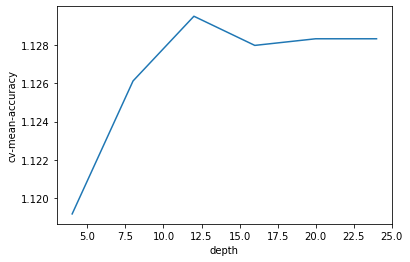

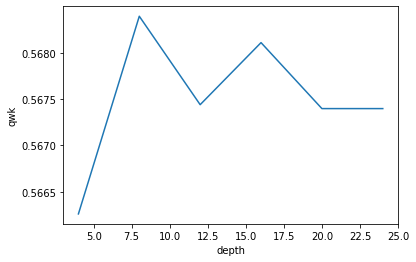

In [95]:
plt.plot(depths,mean_scores);
plt.xlabel("depth");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(depths,qwks_mean);
plt.xlabel("depth");
plt.ylabel("qwk");

# final submission model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'max_depth': 14,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
    }
    
lgb_train = lgb.Dataset(X_train, y_train)       
        
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000)
        
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

y_pred[y_pred <= 1.12232214] = 0
y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
y_pred[y_pred > 2.22506454] = 3
        
#must convert to integer!

y_pred = y_pred.astype(int)
y_pred.dtype

submission = {'installation_id': test_users, 'accuracy_group': y_pred}
sample_submission = pd.DataFrame(submission)
sample_submission.to_csv('submission.csv', index=False)

## 9. Discussion and Takeaways <a id='nine'></a>

There's quite a few things I could have done better (or could have just done at all).

1. I found that the lack of design of the build process for train and test sets led to problems later. In general both design and efficient coding are paramount. The problem was that there were some differences in the build pipeline for test set compared to train. This has to do with the rules of the kaggle competition and how it was structured. Avoid the thematic **error** of not designing the train and test feature building process - do your homework to make this integrated and scalable!!


2. You can actually average the results from multiple models, and then threshold, quote below is from teh 8th place finisher

"Simple average 18 of predictions of 9 models (2 outputs, acc and acc_group per model). then use threshold Optimizer to find thresholds. I randomly initiallized the thresholds for threshold Optimizer around training target distribution, and ran threshold Optimizer 25 times, then chose the one with best cv qwk.
I did a 5 fold simulation(4 folds act as oof we have, 1 fold acts as label of test data) to compare several ways of deciding thresholds. Found that using threshold Optimizer is better than deciding thresholds by simple using training target distributiion."

3. You can use NN or perceptron models!!

4. Feature transformations - log transforms of numeric data

5. Feature interactions

Another thing I didn't do very well was simply organizing my code. It's very important to separate each step and to block your code into separate compartments **of appropriate length, you simply had too small juypyter cells, too many distinct cell code blocks unnesseccarily for a scattered effect** having too long blocks, would also be bad ('spaghetti code')

Another problem I noticed while reviewing my code, is that I named some variables like `gggg` or `hh` instead of giving descriptive names. If you find yourself having to do this, then maybe you are creating temporary variable unneccesarily and can improve the design with nested, more efficient codes. Otherwise, avoid the thematic **error** of using non-descriptive names!!

another thing: avoid thematic **error** of not deleting/dropping unneeded objects to free up memory